In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T

In [2]:
# Load datasets
X_train = pd.read_csv("X_train.csv")  # Peptide sequences
train_labels = pd.read_csv("label_train.csv")  # Corresponding labels

# Combine features and labels
train_data = pd.concat([X_train, train_labels], axis=1)
train_data.columns = ['peptide_sequence', 'label']

# Load test data
X_test = pd.read_csv("X_test.csv")
test_labels = pd.read_csv("label_test.csv")
test_data = pd.concat([X_test, test_labels], axis=1)
test_data.columns = ['peptide_sequence', 'label']

In [3]:
# TF-IDF feature extraction (monogram and bigram)
tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 2))
X_train = tfidf_vectorizer.fit_transform(train_data['peptide_sequence'])
X_test = tfidf_vectorizer.transform(test_data['peptide_sequence'])
y_train = train_data['label']
y_test = test_data['label']

In [4]:
# Check shapes
print(f"Train TF-IDF shape: {X_train.shape}")
print(f"Test TF-IDF shape: {X_test.shape}")

Train TF-IDF shape: (2872, 420)
Test TF-IDF shape: (342, 420)


In [5]:
# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [6]:
# Create PyTorch Geometric data from TF-IDF matrix (convert to sparse tensor)
def create_graph_data(X, y):
    edge_index = torch.tensor([[], []], dtype=torch.long)  # Placeholder for graph edges
    x = torch.tensor(X.toarray(), dtype=torch.float32)    # Feature matrix
    y = torch.tensor(y, dtype=torch.long)                # Labels
    data = Data(x=x, edge_index=edge_index, y=y)
    return data

train_data_graph = create_graph_data(X_train, y_train_encoded)
test_data_graph = create_graph_data(X_test, y_test_encoded)

In [7]:
# Define the Graph Neural Network (GNN) model using GCNConv
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.fc = nn.Linear(output_dim, 2)  # Binary classification (Proinflammatory or not)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)
        return x

In [8]:
# Model parameters
input_dim = X_train.shape[1]  # Number of features
hidden_dim = 64
output_dim = 32

# Initialize model, optimizer, and loss function
model = GNNModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# Training the model
def train(model, data, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [9]:
# Training loop
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    loss = train(model, train_data_graph, optimizer, loss_fn)
    train_losses.append(loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

# Testing the model
def test(model, data):
    model.eval()
    with torch.no_grad():
        output = model(data)
        pred = output.argmax(dim=1)
    return pred

Epoch 10/50, Loss: 0.6198
Epoch 20/50, Loss: 0.5173
Epoch 30/50, Loss: 0.3051
Epoch 40/50, Loss: 0.0833
Epoch 50/50, Loss: 0.0181


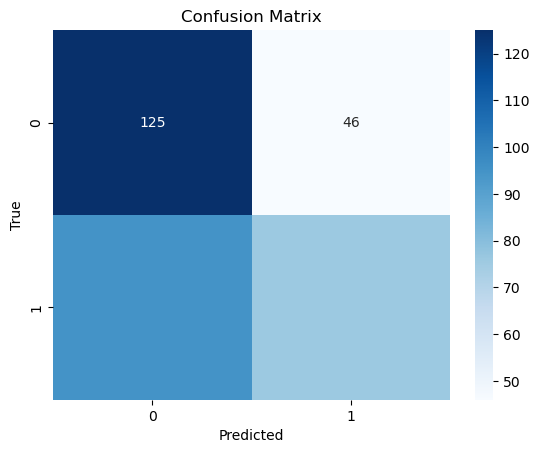

In [10]:
# Test the model
y_test_pred = test(model, test_data_graph)
accuracy_test = accuracy_score(y_test_encoded, y_test_pred)
mcc_test = matthews_corrcoef(y_test_encoded, y_test_pred)

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Test Accuracy: 0.5877192982456141
Test MCC: 0.18311756258961903


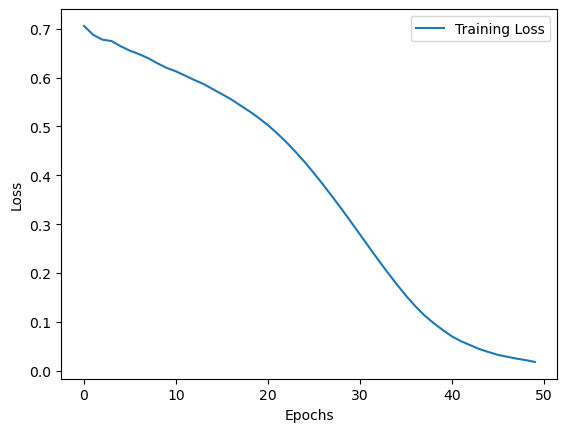

In [11]:
print(f"Test Accuracy: {accuracy_test}")
print(f"Test MCC: {mcc_test}")

# Plot training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Example prediction for a sample peptide
sample_index = 55  # Change this to test other samples
sample_sequence = test_data.iloc[sample_index]['peptide_sequence']
sample_label = test_data.iloc[sample_index]['label']

# Transform the sample using the TF-IDF vectorizer
sample_vector = tfidf_vectorizer.transform([sample_sequence])

# Create a graph for the sample
sample_data = create_graph_data(sample_vector, label_encoder.transform([sample_label]))

# Predict the sample
sample_pred = test(model, sample_data)
sample_pred_label = label_encoder.inverse_transform([sample_pred.item()])[0]

print(f"Sample Sequence: {sample_sequence}")
print(f"True Label: {sample_label} ({'Proinflammatory' if sample_label == 1 else 'Non-Proinflammatory'})")
print(f"Predicted Label: {sample_pred_label} ({'Proinflammatory' if sample_pred_label == 1 else 'Non-Proinflammatory'})")

Sample Sequence: AALALLLLDRLNQLESKMS
True Label: 1 (Proinflammatory)
Predicted Label: 1 (Proinflammatory)
